### Multi-resolution image registration by homography transformation using matrix manifold optimization

In [48]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from skimage.transform import pyramid_gaussian
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm


from google.colab import drive
drive.mount('/content/drive')
#!ls "/content/drive/My Drive"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Mounted at /content/drive
cuda:0


Text(0.5, 1.0, 'Moving Image')

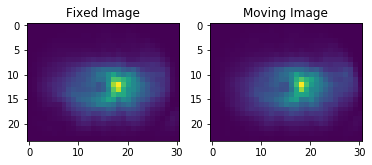

In [49]:
I = io.imread("/content/drive/My Drive/Colab Notebooks/fixed.bmp").astype(np.float32) # fixed image
J = io.imread("/content/drive/My Drive/Colab Notebooks/moving.bmp").astype(np.float32) # fixed image

pyramid_I = tuple(pyramid_gaussian(I, downscale=2, multichannel=False))
pyramid_J = tuple(pyramid_gaussian(J, downscale=2, multichannel=False))
########################################

%matplotlib inline
fig=plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(pyramid_I[7])
plt.title("Fixed Image")
fig.add_subplot(1,2,2)
plt.imshow(pyramid_J[7])         
plt.title("Moving Image")

In [0]:
###############################################################################
H=10
n_epoch = 500
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.f1 = nn.Linear(100, H).to(device)
        self.f2 = nn.Linear(100, H).to(device)
        self.f3 = nn.Linear(H, 100).to(device)

    def forward(self, x, y):
        H1 = F.relu(self.f1(x)+self.f2(y)).to(device)
        H2 = self.f3(H1).to(device)
        return H2    

model = Network()
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)

# def MINE(x_in, y_in):
#     for epoch in tqdm(range(n_epoch)):
#         ################################################
#         idx = torch.randperm(y_in.nelement())
#         y_permute = y_in.view(-1)[idx].view(y_in.size())
# #         y_permute = np.random.permutation(y_in)
# #         x_in = Variable(torch.from_numpy(x_in).type(torch.FloatTensor), requires_grad = True)
# #         y_in = Variable(torch.from_numpy(y_in).type(torch.FloatTensor), requires_grad = True)
# #         y_shuffle = Variable(torch.from_numpy(y_permute).type(torch.FloatTensor), requires_grad = True)   
#         x_in = x_in.to(device)
#         y_in = y_in.to(device)
#         y_permute = y_permute.to(device)
#         ###############################################
        
#         pred_xy = model(x_in, y_in)
#         pred_x_y = model(x_in, y_permute)
        
#         ################################################
#         v_theta =  ( torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y))) )
#         model.zero_grad()
#         v_theta.backward(retain_graph=True)
#         optimizer.step()
#     return v_theta

#################################################################################################
def MINE1(x_in, z_in):
    for epoch in tqdm(range(n_epoch)):
        x_in_1= (x_in.data).cpu().numpy()
        z_in_1= (z_in.data).cpu().numpy()
        z_permute_1 = np.random.permutation(z_in_1)
        hgram1, x_edges, y_edges = np.histogram2d(x_in_1.ravel(), z_in_1.ravel(), bins=100)
        hgram2, x_edges, y_edges = np.histogram2d(x_in_1.ravel(), z_permute_1.ravel(), bins=100)
        pxz_1 = hgram1 / float(np.sum(hgram1))
        pxz_2 = hgram2 / float(np.sum(hgram2))
        px = np.sum(pxz_1,   axis=1)
        pz = np.sum(pxz_2, axis=0)
        
#         y_permute = np.random.permutation(y_in)
#         x_in = Variable(torch.from_numpy(x_in).type(torch.FloatTensor), requires_grad = True)
#         y_in = Variable(torch.from_numpy(y_in).type(torch.FloatTensor), requires_grad = True)
#         y_shuffle = Variable(torch.from_numpy(y_permute).type(torch.FloatTensor), requires_grad = True)   
#         x_in = x_in.to(device)
#         y_in = y_in.to(device)
#         y_permute = y_permute.to(device)
        pxx = torch.from_numpy(px).float().to(device)
        pzz = torch.from_numpy(pz).float().to(device)
        pxxzz_1 = torch.from_numpy(pxz_1).float().to(device)
        ###############################################
        
        pred_xy = model(pxx, pxxzz_1)
        pred_x_y = model(pxx, pzz)
        
        ################################################
        v_theta =  -( torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y))) )
        model.zero_grad()
        v_theta.backward(retain_graph=True)
        optimizer.step()
    return v_theta

In [0]:
def PerspectiveTransform(I, H, xv, yv):
  
  # apply homography
  xvt = (xv*H[0,0]+yv*H[0,1]+H[0,2])/(xv*H[2,0]+yv*H[2,1]+H[2,2])
  yvt = (xv*H[1,0]+yv*H[1,1]+H[1,2])/(xv*H[2,0]+yv*H[2,1]+H[2,2])
  J = F.grid_sample(I.view(1,1,height,width),torch.stack([xvt,yvt],2).unsqueeze(0)).squeeze()
  return J

# def MatrixExp(B, u):
        
#   C = torch.sum(B*u,0)
#   A = torch.eye(3).to(device)
#   H = A + C
#   for i in torch.arange(2,10):
#     A = torch.mm(A/i,C)
#     H = H + A
#   return H
def MatrixExp(B, u):
    C = torch.sum(B*u, 0)
    A = torch.eye(3).to(device)
    H = A
    for i in torch.arange(1,10):
        A =torch.mm(A/i,C)
        H = H + A
    return H

In [64]:
# perspective transform basis matrices

B = torch.zeros(8,3,3).to(device)
B[0,0,2] = 1.0
B[1,1,2] = 1.0
B[2,0,1] = 1.0
B[3,1,0] = 1.0
B[4,0,0], B[4,1,1] = 1.0, -1.0
B[5,1,1], B[5,2,2] = -1.0, 1.0
B[6,2,0] = 1.0
B[7,2,1] = 1.0

# multi-resolution registration
# Consider 8 levels in the pyramid for this example
learning_rate = 1e-5
nItr = torch.tensor([300,300,300,300,400,500,600,600])

torch.autograd.set_detect_anomaly(True)

# create variables and optimization at each level
v = Variable(torch.zeros(8,1,1).to(device), requires_grad=True)
optimizer = optim.Adam([v], lr=learning_rate, amsgrad=True)

for level in torch.arange(7,-1,-1): # start at level 7
  if level>0:
    I = torch.tensor(pyramid_I[level].astype(np.float32)).to(device)
    J = torch.tensor(pyramid_J[level].astype(np.float32)).to(device)
  else:    
    I = torch.tensor(gaussian(pyramid_I[level].astype(np.float32),2.0)).to(device)
    J = torch.tensor(gaussian(pyramid_J[level].astype(np.float32),2.0)).to(device)
  
  height,width = I.shape

  # choose a set of pixel locations on the template image that are most informative
  tval = 0.9*threshold_otsu(I.cpu().numpy()) # reduce Otsu threshold value a bit to cover slightly wider areas
  important_ind = torch.nonzero((I.data>tval).view([height*width])).squeeze()

  # generate grid only once at each level
  yv, xv = torch.meshgrid([torch.arange(0,height).float().to(device), torch.arange(0,width).float().to(device)])
  # map coordinates to [-1,1]x[-1,1] so that grid_sample works properly
  yv = 2.0*yv/(height-1) - 1.0
  xv = 2.0*xv/(width-1) - 1.0
  for itr in range(nItr[level]):
    J_w = PerspectiveTransform(J, MatrixExp(B,v), xv, yv)
    # loss = MINE(J_w.view([height*width])[important_ind], I.view([height*width])[important_ind])
    #loss = F.mse_loss(J_w, I)
    loss = MINE1(I,J_w)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    if itr%100==0:
      loss = MINE1(I,J_w)
      print("Pyramid level:",level.item(),"Iteration:",itr,"MSE loss:",loss.item())
    optimizer.step()

  H = MatrixExp(B,v).detach()
  J_w = PerspectiveTransform(J, H, xv, yv)
  loss = MINE1(I,J_w)
  print("Pyramid level:",level.item(),"Iteration:",itr+1,"MSE loss:",loss.item())

# final transformation
I = torch.tensor(pyramid_I[0].astype(np.float32)).to(device) # without Gaussian
J = torch.tensor(pyramid_J[0].astype(np.float32)).to(device) # without Gaussian
J_w = PerspectiveTransform(J, H, xv, yv)

D = J - I
D_w = J_w - I
print(" ")
print("MSE before registration:",torch.mean(D**2).cpu().item())
print("MSE after registration:",torch.mean(D_w**2).cpu().item())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
  1%|▏         | 7/500 [00:00<00:07, 69.59it/s]

Pyramid level: 7 Iteration: 0 MSE loss: 0.017986156046390533


  1%|▏         | 7/500 [00:00<00:07, 64.83it/s]

Pyramid level: 7 Iteration: 100 MSE loss: 0.017986156046390533


 77%|███████▋  | 387/500 [00:05<00:01, 66.92it/s]


KeyboardInterrupt: ignored

In [0]:
def histogram_mutual_information(image1, image2):
    hgram, x_edges, y_edges = np.histogram2d(image1.ravel(), image2.ravel(), bins=100)
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1)
    py = np.sum(pxy, axis=0)
    px_py = px[:, None] * py[None, :]
    nzs = pxy > 0
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

print("MI before registration:", histogram_mutual_information(pyramid_I[0],pyramid_J[0]))
print("MI after registration:", histogram_mutual_information(pyramid_I[0],J_w.cpu().numpy()))

print(H)
%matplotlib inline
fig=plt.figure(figsize=(30,30))
fig.add_subplot(1,2,1)
plt.imshow(D.cpu().data)
plt.title("Difference image before registration")
fig.add_subplot(1,2,2)
plt.imshow(D_w.cpu().data)         
plt.title("Difference image after registration")

In [24]:
# image1= I
# image2= J
# hgram, x_edges, y_edges = np.histogram2d(image1.ravel(), image2.ravel(), bins=100)
# print(hgram)
# pxy = hgram / float(np.sum(hgram))
# px = np.sum(pxy, axis=1)
# py = np.sum(pxy, axis=0)
# px_py = px[:, None] * py[None, :]
# nzs = pxy > 0
# np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))
I = torch.tensor(pyramid_I[0].astype(np.float32)).to(device)
J = torch.tensor(pyramid_J[0].astype(np.float32)).to(device)
# A = torch.histc(I, bins = 100, min = 0.0, max = 1.0)
# print(A)
x_in = I
y_in = J
x_in_1= (x_in.data).cpu().numpy()
y_in_1= (y_in.data).cpu().numpy()
y_permute_1 = np.random.permutation(y_in_1)
hgram1, x_edges, y_edges = np.histogram2d(x_in_1.ravel(), y_in_1.ravel(), bins=100)
hgram2, x_edges, y_edges = np.histogram2d(x_in_1.ravel(), y_permute_1.ravel(), bins=100)
pxz_1 = hgram1 / float(np.sum(hgram1))
pxz_2 = hgram1 / float(np.sum(hgram2))
px = np.sum(pxz_1,   axis=1)
pz = np.sum(pxz_2, axis=0)
print(pxz_1)

[[0.0002206  0.00380359 0.00424579 ... 0.         0.         0.        ]
 [0.00380709 0.07030357 0.08641435 ... 0.         0.         0.        ]
 [0.00266142 0.05451898 0.07966263 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
